In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import scipy
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [2]:
x1 = pd.read_csv("X1.csv ")
y1 = pd.read_csv("Y1.csv " , header=None , names=['weight'] ) #target
df = x1
df['weight'] = y1

In [3]:
#verification of eventual dataset anomalies
df.isna().any()
#duplicates can have negative influence on the prediction
df.duplicated()
df[df.duplicated()]

,Unnamed: 0,Gender,Age,Height,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,weight


In [4]:
df['BMI'] = df['weight']/(df['Height'])**2
df = df.drop('weight',1)
df

,Unnamed: 0,Gender,Age,Height,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,BMI
0,0,Male,21.0,1.88,yes,yes,3.0,3.0,Sometimes,no,3.0,no,2.0,1.0,Sometimes,Walking,23.766410
1,1,Male,19.0,1.70,yes,yes,2.0,1.0,Sometimes,no,2.0,no,2.0,0.0,Sometimes,Public_Transportation,20.761246
2,2,Male,18.0,1.86,yes,yes,2.0,1.0,Sometimes,yes,2.0,no,1.0,2.0,Sometimes,Public_Transportation,31.795583
3,3,Female,21.0,1.61,yes,yes,3.0,3.0,Sometimes,no,3.0,no,0.0,1.0,Sometimes,Walking,21.025423
4,4,Female,22.0,1.61,yes,yes,3.0,3.0,Frequently,no,3.0,no,1.0,0.0,no,Public_Transportation,24.304618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,245,Female,22.0,1.68,no,yes,3.0,3.0,Frequently,no,2.0,no,0.0,1.0,no,Public_Transportation,18.424036
246,246,Male,23.0,1.65,no,no,3.0,3.0,Sometimes,no,2.0,no,3.0,0.0,no,Public_Transportation,24.242424
247,247,Female,18.0,1.60,yes,yes,3.0,1.0,Sometimes,no,1.0,yes,0.0,2.0,no,Walking,23.437500
248,248,Female,36.0,1.65,yes,yes,2.0,3.0,Sometimes,no,1.0,no,0.0,2.0,no,Automobile,29.384757


In [5]:
df_object=df.select_dtypes(include=['object'])

In [6]:
def cat_into_num(df):
    l = []
    df_object=df.select_dtypes(include=['object'])
    for c in df_object:
        cat = df.loc[:,c]
        facc = pd.factorize(cat)
        l.append(facc)
        df[c] = facc[0]
    return df

df = cat_into_num(df)

In [7]:
import scipy.stats as stats
z_scores = stats.zscore(df)

abs_z_scores = np.abs(z_scores)
#print(abs_z_scores) matrix
filtered_entries = (abs_z_scores < 3).all(axis=1)
df = df[filtered_entries]

In [8]:
df_numerical=df[['Age','Height', 'BMI']] #aggiunto weight
df_categorical = df[['family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC',
                     'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS']] #VARIABILE SMOKE RIMOSSA PERCHè TANTO è SOLO UNN VALORE
df1 = pd.concat([df_numerical,df_categorical],axis =1)
df1

,Age,Height,BMI,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,21.0,1.88,23.766410,0,0,3.0,3.0,0,3.0,0,2.0,1.0,0,0
1,19.0,1.70,20.761246,0,0,2.0,1.0,0,2.0,0,2.0,0.0,0,1
3,21.0,1.61,21.025423,0,0,3.0,3.0,0,3.0,0,0.0,1.0,0,0
4,22.0,1.61,24.304618,0,0,3.0,3.0,1,3.0,0,1.0,0.0,1,1
5,26.0,1.90,22.160665,0,0,2.0,3.0,1,1.0,1,1.0,0.0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,22.0,1.68,18.424036,1,0,3.0,3.0,1,2.0,0,0.0,1.0,1,1
246,23.0,1.65,24.242424,1,1,3.0,3.0,0,2.0,0,3.0,0.0,1,1
247,18.0,1.60,23.437500,0,0,3.0,1.0,0,1.0,1,0.0,2.0,1,0
248,36.0,1.65,29.384757,0,0,2.0,3.0,0,1.0,0,0.0,2.0,1,2


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#SPLIT DATA INTO TRAIN AND TEST SET
def split_std(X,y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size =0.3, #by default is 75%-25%
                                                        #shuffle is set True by default,
                                                        #useful to obtain proportional distribution in 0 and 1
                                                        random_state= 123
                                                       )
    return X_train, X_test, y_train, y_test

In [10]:
import seaborn as sns
def select_features(X,y,n_feat):

    x1 = X
    x1['BMI'] = y
    plt.figure(figsize=(12,10))
    cor = x1.corr()
    #sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
    plt.show()
    trg_cor = (abs(cor['BMI']).sort_values()) #valori dell variabili  
    if n_feat >= len(X.columns):
        slc_feat = X.columns
    
    start = (len(X.columns)-n_feat-1)
    stop = len(X.columns)-1
    
    slc_feat = trg_cor[start:stop].index
    X_sel = X[slc_feat]
    
    return X_sel

In [11]:
def compute_rmse(predict, target):

    if len(target.shape) == 2:
        target = target.squeeze()
    if len(predict.shape) == 2:
        predict = predict.squeeze()
    diff = target-predict
    if len(diff.shape) == 1:
        diff = np.expand_dims(diff, axis=-1)
    rmse = np.sqrt( 1/diff.shape[0] * diff.T@diff )
    return rmse
def scoreweightclass(bmi_pred , bmi_true , low , high):
    tol = 1
    v_pred = (bmi_pred>= (low-tol)) & ( bmi_pred<high+tol)
    v_true = (bmi_true >= low) & (bmi_true < high)
    if v_true.sum()==0:
        print("no true samples here")
        return 0
    
    rmse = np.sqrt(((bmi_true[v_true]-bmi_pred[v_true])**2).mean())
    rmse = rmse / ( high - low+tol ) # normalize rmse ininterval
    acc = (v_pred&v_true).sum() / v_true.sum()
    return rmse*(1-acc)

def scoreregression (ytrue , ypred , height):
    
    bmi_pred = ypred / (height**2)
    bmi_true = ytrue / (height**2)
    scores = []
    for bmi_low , bmi_high in  zip ( [0 ,18.5 ,25 ,30] , [18.5 ,25 ,30 ,100] ) :
        scores.append( scoreweightclass( bmi_pred , bmi_true , low=bmi_low , high=bmi_high) )
    return np.mean(scores)

## BMI prediction: non augmented dataset

In [12]:
def weighttobmi(bmi,isbmi = False, height= None): #bmi means that we have to compute bmi classes from weight
    if type(bmi)!=type(list(bmi)):
        bmi = list(bmi)
    if isbmi == False:
        bmi = list(bmi/height**2)
    #print(bmi)
    ctest = []
    for i in range(len(bmi)):
        if bmi[i]>0 and bmi[i]<18.5:
            ctest.append(0)
        elif bmi[i]>= 18.5 and bmi[i]< 25:
            ctest.append(1)
        elif bmi[i]>= 25 and bmi[i]< 30:
            ctest.append(2)
        elif bmi[i]>= 30:
            ctest.append(3)
    return ctest

In [13]:
from sklearn.svm import SVR
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.model_selection import GridSearchCV


#m = make_scorer(compute_rmse(predict,target)) which is the predict and which the target??

def perform_grid_search(model_, hyper_params_grid, score_function,X_train,y_train,X_test,y_test):
   # score_function = make_scorer(compute_rmse)
    search = GridSearchCV(model_, hyper_params_grid, scoring=score_function, n_jobs=-1, cv=5)
    result = search.fit(X_train, y_train)
    prediction = result.predict(X_test)
    
    print('Best Score: %s' % result.best_score_)
    print('Best Hyperparameters: %s' % result.best_params_)
    
    cprediction = weighttobmi(prediction,isbmi=True)
    ctest = weighttobmi(y_test, isbmi=True) 
    
    from sklearn import metrics
    print()
    print("MAE  train %.3f    test %06.3f" % (metrics.mean_absolute_error(y_train, result.predict(X_train)), metrics.mean_absolute_error(y_test, result.predict(X_test))) ) 
    print("MSE  train %.3f test %.3f" % (metrics.mean_squared_error(y_train, result.predict(X_train)), metrics.mean_squared_error(y_test, result.predict(X_test))) ) 
    print("RMSE train %.3f   test %.3f" % (np.sqrt(metrics.mean_squared_error(y_train, result.predict(X_train))), np.sqrt(metrics.mean_squared_error(y_test, result.predict(X_test)))) ) 
    print("r2   train %.3f     test %.3f" % (metrics.r2_score(y_train, result.predict(X_train)), metrics.r2_score(y_test, result.predict(X_test))) ) 
    print(confusion_matrix(ctest,cprediction,labels = [0,1,2,3]))
    
    return prediction, result

In [14]:
import numpy as np
import matplotlib.pyplot as plt
 
def barplots(mlp, lr, knn, svm, rndf, group):
    # set width of bars
    barWidth = 0.20

    # set heights of bars

    # Set position of bar on X axis
    ro1 = np.arange(len(mlp))
    ro2 = [x + barWidth for x in ro1]
    ro3 = [x + barWidth for x in ro2]
    ro4 = [x + barWidth for x in ro3]
    ro5 = [x + barWidth for x in ro4]
    

    # Make the plot
    plt.bar(ro1, mlp, color='red', width=barWidth, edgecolor='white', label='mlp')
    plt.bar(ro2, lr, color='yellow', width=barWidth, edgecolor='white', label='lr')
    plt.bar(ro3, knn, color='lime', width=barWidth, edgecolor='white', label='knn')
    plt.bar(ro4, svm, color='pink', width=barWidth, edgecolor='white', label='svm')
    plt.bar(ro5, rndf, color='darkgreen', width=barWidth, edgecolor='white', label='rndf')
    

    # Add xticks on the middle of the group bars
    plt.xlabel(group, fontweight='bold')
    plt.xticks([r + barWidth for r in range(len(mlp))], ['MAE', 'MSE/10', 'RMSE', 'R2*10'])

    # Create legend & Show graphic
    plt.legend()
    plt.show()

In [15]:
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

def train_predict(X_train,y_train,X_test,y_test,h):
    mlp = MLPRegressor()
    lr = LinearRegression()
    knn = KNeighborsRegressor()
    svm = SVR()
    rndf = RandomForestRegressor()

    mlp_train = []
    mlp_test = []
    lr_train = []
    lr_test = []
    knn_train = []
    knn_test = []
    svm_train = []
    svm_test = []
    rndf_train = []
    rndf_test = []


    for i in [mlp, lr, knn, svm,rndf]:
        if i==mlp:
            model = mlp
            print('MLPRegressor')
            hyper_params_grid = {'hidden_layer_sizes':[(20,20),(40,40)],'activation':['logistic', 'tanh','relu'], 'solver':['lbfgs', 'adam'], 'alpha':[0.001,0.01,0.1],'learning_rate':['constant', 'invscaling', 'adaptive'],'max_iter':[400,600],'random_state':[43]}
            grid_predictions, result = perform_grid_search(model,hyper_params_grid,'neg_root_mean_squared_error',X_train,y_train,X_test,y_test )
            print(scoreregression(y_test*(h**2), grid_predictions*(h**2), h))
            mlp_train.append(metrics.mean_absolute_error(y_train, result.predict(X_train)))
            mlp_train.append(metrics.mean_squared_error(y_train, result.predict(X_train))/10)
            mlp_train.append(np.sqrt(metrics.mean_squared_error(y_train, result.predict(X_train))))
            mlp_train.append(abs(metrics.r2_score(y_train, result.predict(X_train))*10))
            
            mlp_test.append(metrics.mean_absolute_error(y_test, result.predict(X_test)))
            mlp_test.append(metrics.mean_squared_error(y_test, result.predict(X_test))/10)
            mlp_test.append(np.sqrt(metrics.mean_squared_error(y_test, result.predict(X_test))))
            mlp_test.append(abs(metrics.r2_score(y_test, result.predict(X_test))*10))
        if i==lr:
            model = lr
            print('LinearRegressor')
            hyper_params_grid = {'n_jobs':[-1]}
            grid_predictions, result = perform_grid_search(model,hyper_params_grid,'neg_root_mean_squared_error',X_train,y_train,X_test,y_test)
            print(scoreregression(y_test*(h**2), grid_predictions*(h**2), h))
            lr_train.append(metrics.mean_absolute_error(y_train, result.predict(X_train)))
            lr_train.append(metrics.mean_squared_error(y_train, result.predict(X_train))/10)
            lr_train.append(np.sqrt(metrics.mean_squared_error(y_train, result.predict(X_train))))
            lr_train.append(abs(metrics.r2_score(y_train, result.predict(X_train))*10))
            
            lr_test.append(metrics.mean_absolute_error(y_test, result.predict(X_test)))
            lr_test.append(metrics.mean_squared_error(y_test, result.predict(X_test))/10)
            lr_test.append(np.sqrt(metrics.mean_squared_error(y_test, result.predict(X_test))))
            lr_test.append(abs(metrics.r2_score(y_test, result.predict(X_test))*10))
        if i==knn:
            model = knn
            print('KNN')
            hyper_params_grid = {'n_neighbors':[5,10,20,30],'weights':['uniform', 'distance'],'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']}
            grid_predictions, result = perform_grid_search(model,hyper_params_grid,'neg_root_mean_squared_error',X_train,y_train,X_test,y_test) 
            print(scoreregression(y_test*(h**2), grid_predictions*(h**2), h))
            knn_train.append(metrics.mean_absolute_error(y_train, result.predict(X_train)))
            knn_train.append(metrics.mean_squared_error(y_train, result.predict(X_train))/10)
            knn_train.append(np.sqrt(metrics.mean_squared_error(y_train, result.predict(X_train))))
            knn_train.append(abs(metrics.r2_score(y_train, result.predict(X_train))*10))
            
            knn_test.append(metrics.mean_absolute_error(y_test, result.predict(X_test)))
            knn_test.append(metrics.mean_squared_error(y_test, result.predict(X_test))/10)
            knn_test.append(np.sqrt(metrics.mean_squared_error(y_test, result.predict(X_test))))
            knn_test.append(abs(metrics.r2_score(y_test, result.predict(X_test))*10))
        if i==svm:
            model = svm
            print('SVM')
            hyper_params_grid = { 'kernel':['poly', 'rbf', 'sigmoid'], 'gamma': ['scale', 'auto'] }
            grid_predictions, result = perform_grid_search(model,hyper_params_grid,'neg_root_mean_squared_error',X_train,y_train,X_test,y_test )
            print(scoreregression(y_test*(h**2), grid_predictions*(h**2), h))
            svm_train.append(metrics.mean_absolute_error(y_train, result.predict(X_train)))
            svm_train.append(metrics.mean_squared_error(y_train, result.predict(X_train))/10)
            svm_train.append(np.sqrt(metrics.mean_squared_error(y_train, result.predict(X_train))))
            svm_train.append(abs(metrics.r2_score(y_train, result.predict(X_train))*10))
            
            svm_test.append(metrics.mean_absolute_error(y_test, result.predict(X_test)))
            svm_test.append(metrics.mean_squared_error(y_test, result.predict(X_test))/10)
            svm_test.append(np.sqrt(metrics.mean_squared_error(y_test, result.predict(X_test))))
            svm_test.append(abs(metrics.r2_score(y_test, result.predict(X_test))*10))
        if i == rndf:
            model = rndf
            print('RandomForestRegressor')
            hyper_params_grid = {'n_estimators':[50,100,200],'criterion':['squared_error', 'absolute_error', 'poisson'], 'max_depth':[4,7],'random_state':[42]}
            grid_predictions, result = perform_grid_search(model,hyper_params_grid,'neg_root_mean_squared_error',X_train,y_train,X_test,y_test) 
            print(scoreregression(y_test*(h**2), grid_predictions*(h**2), h))
            rndf_train.append(metrics.mean_absolute_error(y_train, result.predict(X_train)))
            rndf_train.append(metrics.mean_squared_error(y_train, result.predict(X_train))/10)
            rndf_train.append(np.sqrt(metrics.mean_squared_error(y_train, result.predict(X_train))))
            rndf_train.append(abs(metrics.r2_score(y_train, result.predict(X_train))*10))
            
            rndf_test.append(metrics.mean_absolute_error(y_test, result.predict(X_test)))
            rndf_test.append(metrics.mean_squared_error(y_test, result.predict(X_test))/10)
            rndf_test.append(np.sqrt(metrics.mean_squared_error(y_test, result.predict(X_test))))
            rndf_test.append(abs(metrics.r2_score(y_test, result.predict(X_test))*10))


    barplots(mlp_train, lr_train, knn_train, svm_train, rndf_train, "Train")
    barplots(mlp_test, lr_test, knn_test, svm_test, rndf_test, "Test")

<Figure size 864x720 with 0 Axes>

MLPRegressor
Best Score: -3.944830028310715
Best Hyperparameters: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (20, 20), 'learning_rate': 'constant', 'max_iter': 600, 'random_state': 43, 'solver': 'lbfgs'}

MAE  train 2.598    test 02.908
MSE  train 12.517 test 14.232
RMSE train 3.538   test 3.772
r2   train 0.149     test 0.097
[[ 0  3  0  0]
 [ 0 39  0  0]
 [ 0 13  5  0]
 [ 0  4  3  0]]
0.17970179611602236
LinearRegressor
Best Score: -3.7330867582407015
Best Hyperparameters: {'n_jobs': -1}

MAE  train 2.598    test 02.908
MSE  train 12.516 test 14.230
RMSE train 3.538   test 3.772
r2   train 0.149     test 0.097
[[ 0  3  0  0]
 [ 0 39  0  0]
 [ 0 13  5  0]
 [ 0  4  3  0]]
0.17969271427463407
KNN
Best Score: -3.688766999237142
Best Hyperparameters: {'algorithm': 'ball_tree', 'n_neighbors': 30, 'weights': 'uniform'}

MAE  train 2.681    test 03.262
MSE  train 12.902 test 17.431
RMSE train 3.592   test 4.175
r2   train 0.123     test -0.106
[[ 0  3  0  0]
 [ 0 37  2  0]
 

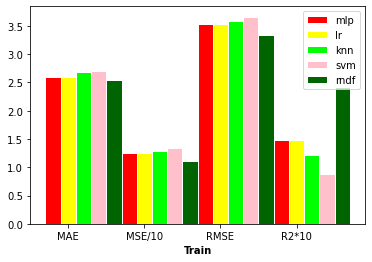

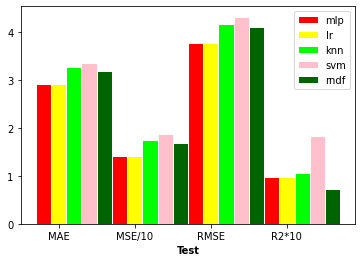

In [16]:
y = df1['BMI']
X = df1.drop(["BMI"], 1)

y = y.reset_index(drop=True)
X = X.reset_index(drop=True)
X_fake_train, X_fake_test, y_fake_train, y_fake_test = split_std(X,y)

mm_scaler =  MinMaxScaler(copy=False,feature_range=(-1, 1))
Xs= pd.DataFrame(mm_scaler.fit_transform(X))
Xs.columns = X.columns


df_sel = select_features(X,y,7)


X_train, X_test, y_train, y_test = split_std(df_sel,y)
train_predict(X_train,y_train,X_test,y_test,X_fake_test['Height'])

## BMI prediction: augmented dataset

In [17]:
#pip install tabgan
from tabgan.sampler import OriginalGenerator, GANGenerator
from sklearn.model_selection import train_test_split

In [18]:
X = df1.drop('BMI',1)
y = df1['BMI']

<Figure size 864x720 with 0 Axes>

C:\Users\IreRi\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\IreRi\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\IreRi\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument

MLPRegressor


C:\Users\IreRi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


Best Score: -3.6831825211258247
Best Hyperparameters: {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (40, 40), 'learning_rate': 'constant', 'max_iter': 400, 'random_state': 43, 'solver': 'adam'}

MAE  train 2.465    test 03.235
MSE  train 11.899 test 17.243
RMSE train 3.450   test 4.152
r2   train 0.161     test -0.094
[[ 0  3  0  0]
 [ 1 38  0  0]
 [ 0 18  0  0]
 [ 0  7  0  0]]
0.24498614467853305
LinearRegressor
Best Score: -3.7183627245602247
Best Hyperparameters: {'n_jobs': -1}

MAE  train 2.521    test 02.908
MSE  train 11.336 test 14.488
RMSE train 3.367   test 3.806
r2   train 0.201     test 0.081
[[ 0  3  0  0]
 [ 0 36  3  0]
 [ 0 12  6  0]
 [ 0  4  3  0]]
0.17573127595917482
KNN
Best Score: -3.589570885917291
Best Hyperparameters: {'algorithm': 'auto', 'n_neighbors': 30, 'weights': 'distance'}

MAE  train 0.177    test 03.523
MSE  train 0.387 test 22.018
RMSE train 0.622   test 4.692
r2   train 0.973     test -0.397
[[ 0  3  0  0]
 [ 1 33  4  1]
 [ 0 15  3  0]
 [ 0

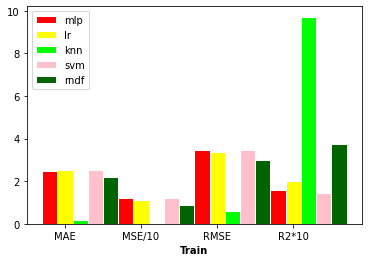

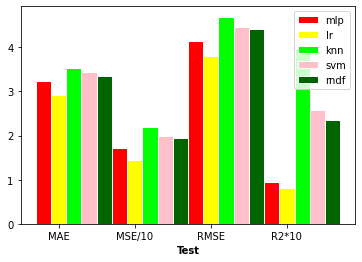

In [19]:
y = df1['BMI']
X = df1.drop(['BMI'], 1)

y = y.reset_index(drop=True)
X = X.reset_index(drop=True)
X_fake_train, X_fake_test, y_fake_train, y_fake_test = split_std(X,y)

mm_scaler =  MinMaxScaler(copy=False,feature_range=(-1, 1))
Xs= pd.DataFrame(mm_scaler.fit_transform(X))
Xs.columns = X.columns


df_sel = select_features(X,y,7)


X_train, X_test, y_train, y_test = split_std(df_sel,y)

new_train, new_target = OriginalGenerator().generate_data_pipe(X_train, pd.DataFrame(y_train), X_test, )

train_predict(new_train,new_target,X_test,y_test,X_fake_test['Height'])